In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os
import numpy as np
import glob
from PIL import Image
from sklearn.cluster import KMeans
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.decomposition import PCA

In [2]:
vgg16 = models.vgg16(pretrained=True,progress=True)
# print(vgg16)

In [3]:
# 最後の3つのlayer(relu,dropout,fc1000)を削除
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
vgg16fc7 = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-3]  
)

# print(vgg16fc7)

In [6]:
#特徴抽出　保存
imglist=glob.glob('scene/*.jpg')
in_size=256
imgs = np.empty((0,in_size,in_size,3), dtype=np.float32)

for i,img_path in enumerate(imglist):
    if i%100==0:
        print("reading {}th image".format(i))
        
    x = np.array(Image.open(img_path).resize((in_size,in_size)), dtype=np.float32)
    x = np.expand_dims(x, axis=0)
    imgs = np.vstack((imgs,x))
    
# (300, 256, 256, 3)->(300, 3, 256, 256)
mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
std=np.array([0.229, 0.224, 0.225], dtype=np.float32)
imgs=(imgs/255.0-mean)/std
imgs=imgs.transpose(0,3,1,2)  # HWC -> CHW
img=torch.from_numpy(imgs)
print(img.shape)
torch.save(img, 'scene/img.pt')

reading 0th image
torch.Size([100, 3, 256, 256])


In [5]:
device = 'cpu'
vgg16fc7 = vgg16fc7.to(device)

vgg16fc7.eval()
with torch.no_grad():
    fc=vgg16fc7(torch.load('scene/img.pt').to(device)).cpu().numpy()
print(fc.shape)     # shapeの表示
np.save('fc7.npy', fc)

(100, 4096)


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
fc7 = np.load('scene/fc7.npy')
fc7.shape

(100, 4096)

In [11]:
#k-means及び10個から5つのクラスタ－毎に4枚づつ出力
def imshow(feature):
    kmeans_model = KMeans(n_clusters=10, random_state=10).fit_predict(feature)
    imglist=glob.glob('scene/*.jpg')
    img_num = 4
    cluster = 5
    group = 3
    for j in range(0,cluster):
        for i in range(0,img_num):
            index = np.where(kmeans_model==j)[0][i]
            plt.subplot(cluster,img_num,(img_num*j)+(i+1))
            plt.imshow(Image.open(imglist[index]).resize((550,300)))
            plt.axis('off')

## 主成分分析
### __結果の画像は横軸が1つのクラスター__

## 4096次元

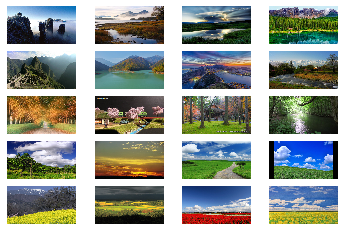

In [12]:
imshow(fc7)

## 累積寄与率95％  

In [13]:
features = fc7
# 主成分分析する
pca = PCA(n_components=47)
pca.fit(features)
# 分析結果を元にデータセットを主成分に変換する
transformed = pca.fit_transform(features)
# 主成分の寄与率を出力する
print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

各次元の寄与率: [0.19029585 0.10457635 0.07415072 0.06417076 0.05107949 0.04581884
 0.037222   0.0317129  0.02892887 0.02548377 0.02207731 0.02055214
 0.01953153 0.0183174  0.01548025 0.01349333 0.01333676 0.01214346
 0.01111618 0.01072779 0.00987327 0.00935156 0.00866551 0.00841533
 0.00771745 0.00720032 0.00703287 0.00673014 0.00622009 0.00604906
 0.00539566 0.00517773 0.00506222 0.00476361 0.0046516  0.00440934
 0.00404004 0.00378278 0.00361441 0.00346496 0.00328488 0.00315816
 0.00289419 0.00284997 0.00275908 0.00257641 0.00253189]
累積寄与率: 0.9518882073462009


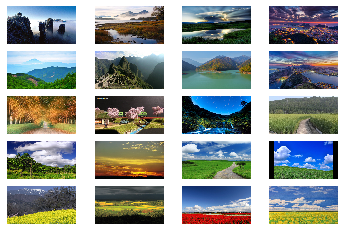

In [14]:
imshow(transformed)

## 累積寄与率90％

In [227]:
features = fc7
# 主成分分析する
pca = PCA(n_components=32)
pca.fit(features)
# 分析結果を元にデータセットを主成分に変換する
transformed = pca.fit_transform(features)
# 主成分の寄与率を出力する
print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

各次元の寄与率: [0.19029573 0.10457622 0.07415075 0.06417068 0.05107943 0.04581881
 0.03722208 0.03171292 0.02892888 0.0254838  0.0220773  0.02055214
 0.01953156 0.01831743 0.01548025 0.01349332 0.01333676 0.01214346
 0.01111615 0.01072775 0.0098732  0.0093514  0.00866505 0.00841515
 0.0077172  0.00719849 0.00702997 0.00672864 0.00621896 0.00604448
 0.00538396 0.00516373]
累積寄与率: 0.8980056559666991


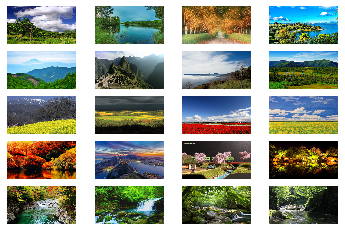

In [228]:
imshow(transformed)

# 考察
PCAを用いて次元圧縮を行いクラスタリングをした。4096次元と累積寄与率が95％の場合の実行結果はほとんど同じ結果であることが分かった。これは寄与率が高いことによって圧縮前のデータに近く、必要最低限の特徴を残して圧縮したからであると考えられる。累積寄与率が90％の時は他の結果よりもうまくクラスタリングされているように見えた。これは、寄与率が下がったことによって、さらに画像の特徴が大雑把に似ているものをある次元にまとめたことによって、実際の画像の初見の見た目が他の手法と比べて似ているように感じたと考えられる。